In [1]:
import ssgetpy
from scipy.io import mmread 
from scipy.sparse import csr_matrix, eye, spdiags
from scipy.sparse.linalg import inv, eigsh
from numpy.linalg import cond
import numpy as np
import os
import time 

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
import matplotlib

import seaborn as sns
import pandas as pd

sns.set_theme()

In [2]:
matrix = ssgetpy.search(rowbounds=(100_000,150_000),
               colbounds=(100_000,150_000),
               nzbounds = (0,1_000_000), 
               isspd = True)
matrix

2257,Botonakis,thermomech_TC,102158,102158,711558,real,Yes,Yes,1.0,1.0,thermal problem,
2258,Botonakis,thermomech_TK,102158,102158,711558,real,Yes,Yes,1.0,1.0,thermal problem,


In [3]:
# matrix.download(destpath = f'{os.getcwd()}\\matrix',extract=True)

In [65]:
# matrix = mmread('matrix\\torsion1\\torsion1.mtx')
# matrix = mmread('matrix\\obstclae\\obstclae.mtx')
# matrix = mmread('matrix\\Dubcova1\\Dubcova1.mtx')
# matrix = mmread('matrix\\jnlbrng1\\jnlbrng1.mtx') #
# matrix = mmread('matrix\\thermomech_TC\\thermomech_TC.mtx') #
matrix = mmread('matrix\\dubcova3\\dubcova3.mtx')

matrix = csr_matrix(matrix)
b = np.zeros((matrix.shape[0],1))
seed = 14062022
# np.random.seed(seed)

matrix

<146689x146689 sparse matrix of type '<class 'numpy.float64'>'
	with 3636649 stored elements in Compressed Sparse Row format>

In [66]:
max_eig = np.abs(eigsh(matrix, k = 1, which='LM',return_eigenvectors=False)[0])
min_eig = np.abs(eigsh(matrix, k = 1, which='SM',return_eigenvectors=False)[0])

In [67]:
max_eig/min_eig

3986.9268951527897

In [68]:
n = matrix.shape[0]
M = matrix.diagonal()
M_inv = spdiags(np.divide(eye(n).data,M), diags= 0,  m = n, n = n)
M_A = M_inv.dot(matrix)

In [91]:
max_eig = np.abs(eigsh(M_A, k = 1, which='LM',return_eigenvectors=False)[0])
min_eig = np.abs(eigsh(M_A, k = 1, which='SM',return_eigenvectors=False)[0])

In [94]:
max_eig/min_eig

618075.9993417613

In [45]:
def plot_conv(itters,results,metodo):
    fig,ax = plt.subplots(figsize = (20,5))

    ax.plot(itters,
            np.log10(results),
            '-o',markersize=5)

    plt.title("Convergência "+ metodo)
    plt.xlabel("Iterações")
    plt.ylabel("Log10 Norma L2 x_k")
    plt.show()

### Steepest Descent

In [46]:
def steepest_descent(A,b,qtd,tol):
    n = A.shape[0]
    x = np.random.rand(n,1)

    itters = [0]
    results = [np.linalg.norm(x,2)]
    
    res = np.subtract(b, A.dot(x))
    alfa_num = np.matrix.transpose(res).dot(res)
    
    for i in range(qtd):
        q = A.dot(res)
        alfa_deno = np.matrix.transpose(res).dot(q)
        alfa = np.divide(alfa_num, alfa_deno)
        
        x = np.add(x, alfa*res)
    
        norm_x = np.linalg.norm(x,2)
        
        itters.append(i+1)
        results.append(norm_x)
        
        if(i % 50 == 0):
            res = np.subtract(b, A.dot(x))
        else:
            res = np.subtract(res, alfa*q)
            
        alfa_num = np.matrix.transpose(res).dot(res)
        
        if norm_x <= tol:
            return (itters,results)

    return False

In [71]:
np.random.seed(seed)
itters_sd,results_sd = steepest_descent(matrix,b,qtd = 10**9,tol = 1e-8)

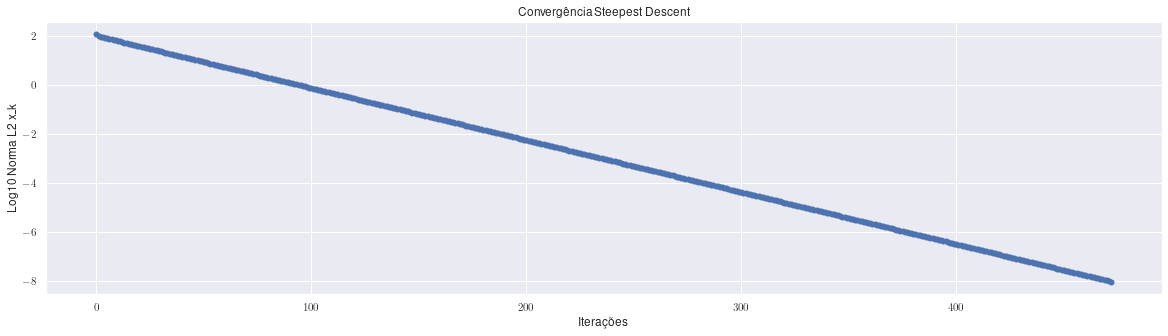

In [48]:
plot_conv(itters_sd,results_sd,"Steepest Descent")

### Steepest Descent Diagonal Preconditioned

In [49]:
def steepest_descent_diagonal(A,b,qtd,tol):
    n = A.shape[0]
    x = np.random.rand(n,1)
    
    itters = [0]
    results = [np.linalg.norm(x,2)]
    
    res = np.subtract(b, A.dot(x))
    M = A.diagonal()
    M_inv = spdiags(np.divide(eye(n).data, M), diags= 0,  m = n, n = n)
    z = M_inv.dot(res)
    alfa_num = np.matrix.transpose(z).dot(res)
    
    for i in range(qtd):
        
        q = A.dot(z)
        alfa_deno = np.matrix.transpose(z).dot(q)
        alfa = np.divide(alfa_num,alfa_deno)
        
        x = np.add(x, alfa*z)
        
        norm_x = np.linalg.norm(x,2)
        
        itters.append(i+1)
        results.append(norm_x)
        
        if(i % 50 == 0):
            res = np.subtract(b, A.dot(x))
        else:
            res = np.subtract(res, alfa*q)
        
        z = M_inv.dot(res)
        
        alfa_num = np.matrix.transpose(z).dot(res)
        
        if  norm_x  <= tol:
            return (itters,results)

    return False

In [72]:
%%time
np.random.seed(seed)
itters_sdd,results_sdd = steepest_descent_diagonal(matrix,b,qtd = 10**9,tol = 1e-8)

CPU times: total: 7min 35s
Wall time: 7min 39s


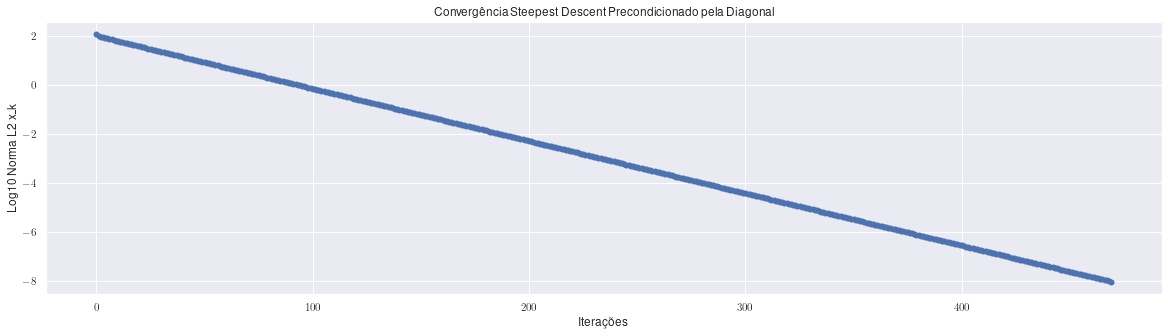

In [51]:
plot_conv(itters_sdd,results_sdd,"Steepest Descent Precondicionado pela Diagonal")

### Conjugate Gradients

In [17]:
def conjugate_gradient(A,b,qtd,tol):
    x = np.random.rand(A.shape[0],1)
    
    itters = [0]
    results = [np.linalg.norm(x,2)]
    
    res = np.subtract(b, A.dot(x))
    res_t = np.matrix.transpose(res)
    d = res
    delta_new = res_t.dot(res)
    
    for i in range(qtd):
        q = A.dot(d)
        alpha = np.divide(delta_new, (np.matrix.transpose(d).dot(q)))
        
        x = np.add(x, alpha*d)
        
        norm_x = np.linalg.norm(x,2)
        
        if(i % 50 == 0):
            res = np.subtract(b, (A.dot(x)))
        else:
            res = np.subtract(res, alpha*q)
        
        delta_old = delta_new
        delta_new = np.matrix.transpose(res).dot(res)
        beta = np.divide(delta_new, delta_old)
        d = np.add(res, beta*d)
        
        itters.append(i+1)
        results.append(np.linalg.norm(x,2))
        
        if norm_x <= tol:
            return (itters,results)
    
    return False

In [73]:
%%time
np.random.seed(seed)
itters_cg,results_cg = conjugate_gradient(matrix,b,qtd = 10**9,tol = 1e-8)

CPU times: total: 3.2 s
Wall time: 3.16 s


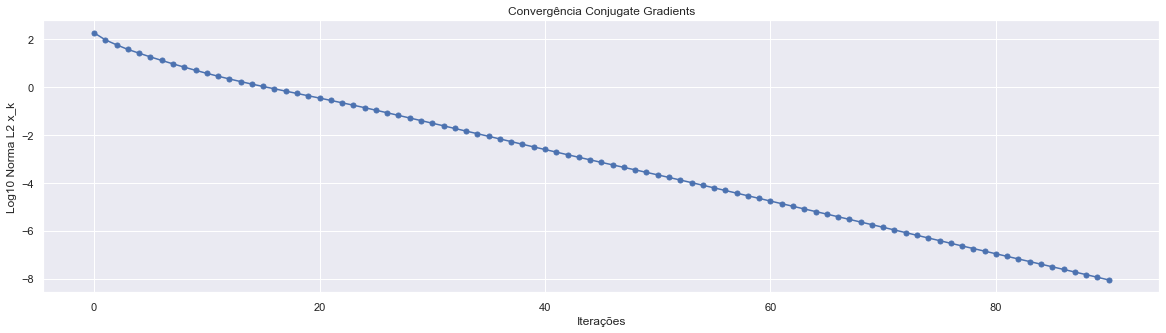

In [19]:
plot_conv(itters_cg,results_cg,"Conjugate Gradients")

### Conjugate Gradients Diagonal Preconditioned

In [20]:
def conjugate_gradient_diagonal(A,b,qtd,tol):
    n = A.shape[0]
    x = np.random.rand(n,1)
    
    itters = [0]
    results = [np.linalg.norm(x,2)]
    
    res = np.subtract(b, A.dot(x))
    res_t = np.matrix.transpose(res)
    M = matrix.diagonal()
    M_inv = spdiags(np.divide(eye(n).data, M), diags= 0,  m = n, n = n)
    d = M_inv.dot(res)
    delta_new = res_t.dot(d)
    
    for i in range(qtd):
        q = A.dot(d)
        alpha = np.divide(delta_new, (np.matrix.transpose(d).dot(q)))
        
        x = np.add(x, alpha*d)
        norm_x = np.linalg.norm(x,2)
        
        if(i % 50 == 0):
            res = np.subtract(b, (A.dot(x)))
        else:
            res = np.subtract(res, alpha*q)
        
        s = M_inv.dot(res)
        delta_old = delta_new
        delta_new = np.matrix.transpose(res).dot(s)
        beta = np.divide(delta_new,delta_old)
        d = np.add(s, beta*d)
        
        itters.append(i+1)
        results.append(norm_x)
        
        if norm_x <= tol:
            return (itters,results)
    
    return False

In [74]:
%%time
np.random.seed(seed)
itters_cgd,results_cgd = conjugate_gradient_diagonal(matrix,b,qtd = 10**9,tol = 1e-8)

CPU times: total: 3.36 s
Wall time: 3.33 s


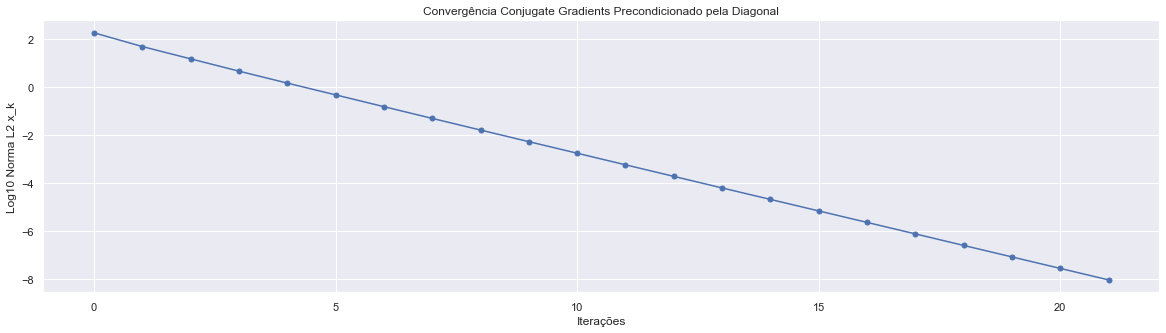

In [22]:
plot_conv(itters_cgd,results_cgd,"Conjugate Gradients Precondicionado pela Diagonal")

In [23]:
num = 50
for i in range(num):
    np.random.seed(seed)
    itters_sd,results_sd = steepest_descent(matrix,b,qtd = 10**9,tol = 1e-8)
    
    np.random.seed(seed)
    start_sdd = time.time()
    itters_sdd,results_sdd = steepest_descent_diagonal(matrix,b,qtd = 10**9,tol = 1e-8)

    np.random.seed(seed)
    itters_cg,results_cg = conjugate_gradient(matrix,b,qtd = 10**9,tol = 1e-8)

    np.random.seed(seed)
    itters_cgd,results_cgd = conjugate_gradient_diagonal(matrix,b,qtd = 10**9,tol = 1e-8)

In [84]:
time_sd = time_sdd = time_cg = time_cgd = 0 

num = 1
for i in range(num):
    np.random.seed(seed)
    start_sd = time.time()
    itters_sd,results_sd = steepest_descent(matrix,b,qtd = 10**9,tol = 1e-8)
    end_sd = time.time()
    time_sd += end_sd - start_sd

    np.random.seed(seed)
    start_sdd = time.time()
    itters_sdd,results_sdd = steepest_descent_diagonal(matrix,b,qtd = 10**9,tol = 1e-8)
    end_sdd = time.time()
    time_sdd += end_sdd - start_sdd

    np.random.seed(seed)
    start_cg = time.time()
    itters_cg,results_cg = conjugate_gradient(matrix,b,qtd = 10**9,tol = 1e-8)
    end_cg = time.time()
    time_cg += end_cg - start_cg

    np.random.seed(seed)
    start_cgd = time.time()
    itters_cgd,results_cgd = conjugate_gradient_diagonal(matrix,b,qtd = 10**9,tol = 1e-8)
    end_cgd = time.time()
    time_cgd += end_cgd - start_cgd

time_sd = time_sd/num
time_sdd = time_sdd/num
time_cg = time_cg/num
time_cgd = time_cgd/num

In [25]:
print([time_sd,time_sdd,time_cg,time_cgd])

[1.3672997403144835, 0.12227031230926513, 0.25096004486083984, 0.06626479148864746]


### Gráfico Tempo

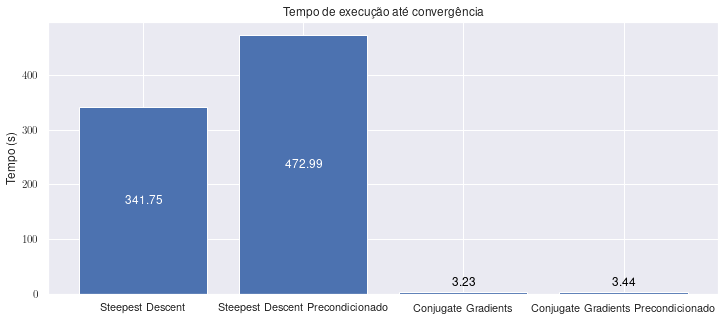

In [90]:
fig, (ax1) = plt.subplots(nrows=1,ncols=1, figsize = (12,5), sharex=True, sharey=True)


x = ["Steepest Descent","Steepest Descent Precondicionado","Conjugate Gradients","Conjugate Gradients Precondicionado"]
y = [time_sd,time_sdd,time_cg,time_cgd]
ax1.bar(x, y)
for i,t in enumerate(y):
    if(t < 200):
        ax1.text(i,20,s=round(t,2),ha="center",va="center",c="black",fontdict={'size':12})
    else:
        ax1.text(i,t/2,s=round(t,2),ha="center",va="center",c="w",fontdict={'size':12})

ax1.set_title('Tempo de execução até convergência')
ax1.set_ylabel('Tempo (s)')

plt.show()

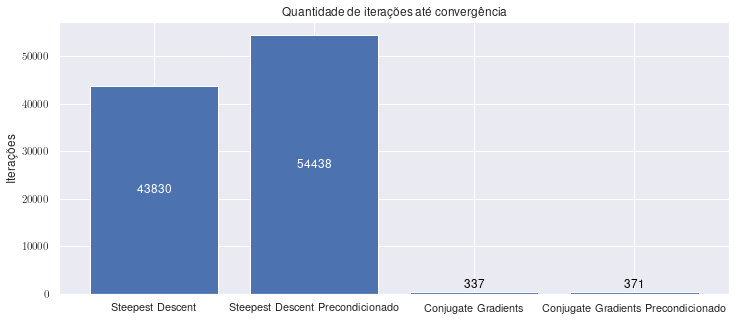

In [81]:
fig, (ax1) = plt.subplots(nrows=1,ncols=1, figsize = (12,5), sharex=True, sharey=True)


x = ["Steepest Descent","Steepest Descent Precondicionado","Conjugate Gradients","Conjugate Gradients Precondicionado"]
y = [len(results_sd),len(results_sdd),len(results_cg),len(results_cgd)]
ax1.bar(x, y)
for i,t in enumerate(y):
    if(t < 1000):
        ax1.text(i,2000,s=round(t,2),ha="center",va="center",c="black",fontdict={'size':12})
    else:
        ax1.text(i,t/2,s=round(t,2),ha="center",va="center",c="w",fontdict={'size':12})

ax1.set_title('Quantidade de iterações até convergência')
ax1.set_ylabel('Iterações')

plt.show()

### Gráfico Iterações

In [77]:
results = pd.DataFrame()
results["Steepest Descent"] = pd.Series(results_sd)
results["Steepest Descent Precondicionado"] = pd.Series(results_sdd)
results["Conjugate Gradients"] = pd.Series(results_cg)
results["Conjugate Gradients Precondicionado"] = pd.Series(results_cgd)


In [63]:
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica",
  "font.size":12
})

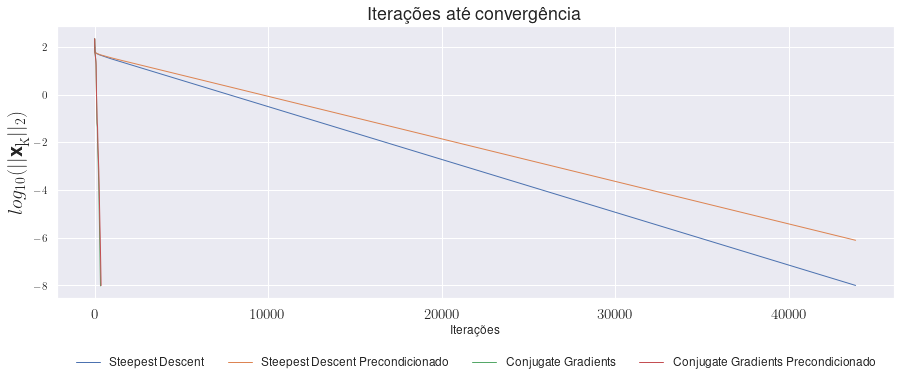

In [79]:
fig, (ax1) = plt.subplots(nrows=1, figsize = (15,5), sharex=True)
# markers_char = ["|", "x", "*", "s"]
met = results.columns
# markers = dict(zip(queries,markers_char))



for q in met:
    x = results.index
    y = np.log10(results[q])
#     ax1.plot(x, y, linewidth=1,marker=markers[q],label=q)
    ax1.plot(x, y, linewidth=1, label=q)
#     ax1.scatter(x, y, marker="x")

ax1.legend(loc='lower center', ncol=7, frameon=False, bbox_to_anchor=(.5, -.30),prop ={'size':12})

plt.xticks(fontsize=15)
# ax1.set_xticks((25,50,75,100,600,625))

ax1.set_title('Iterações até convergência',fontdict={'size':18})
ax1.set_ylabel(r'$log_{10}(||\textbf{x}_\textrm{k}||_2)$',fontdict={'size':20})

# ax1.set_ylabel(r'$\sum_{i=0}^\infty x_i$')
ax1.set_xlabel('Iterações',fontdict={'size':12})

plt.show()